In [1]:
import test_config as cfg
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import os, os.path
import pickle
import io

import skimage
import skimage.io, skimage.transform, skimage.filters

import sys
sys.path.append(r'../src/')

In [2]:
import importlib
import transform
importlib.reload(transform)

<module 'transform' from '../src\\transform.py'>

In [3]:
src_fname = os.path.join(cfg.sample_path, os.listdir(cfg.sample_path)[7])
print(src_fname)
src = skimage.io.imread(src_fname, as_grey=True)

D:/Data/bujo_sample\20190309_125153.jpg


C:\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


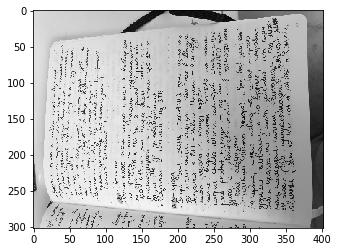

In [4]:
src2 = skimage.transform.rescale(src, scale=0.1)
plt.imshow(src2, cmap='gray')

In [5]:
res = transform.get_text_angle(src2)
print(res[0][0])

C:\Anaconda3\lib\site-packages\skimage\transform\radon_transform.py:69: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


1.1166253101737027


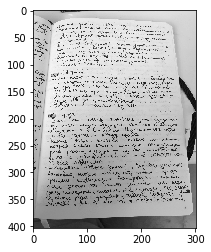

In [231]:
src3 = skimage.transform.rotate(src2, -90.0-res[0][0], resize=True)
srcr = skimage.transform.rotate(src, -90.0-res[0][0], resize=True)
plt.imshow(src3, cmap='gray')

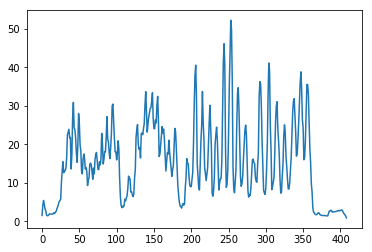

In [7]:
src3v = np.sum(np.abs(src3[:,1:]-src3[:,:-1]), axis=1)
plt.plot(src3v)

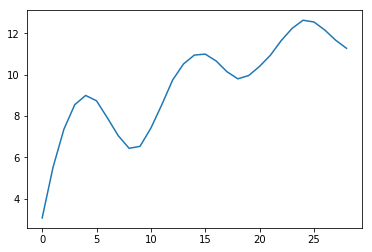

In [8]:
src4 = np.array([np.mean(np.abs(src3v[i:]-src3v[:-i])) for i in range(1, 30)])
plt.plot(src4)

In [9]:
loc_maximas = np.array(range(len(src4)))[np.r_[True, src4[1:] < src4[:-1]] & np.r_[src4[:-1] < src4[1:], True]]
best_freq = min([x for x in loc_maximas if x > 0])
print(best_freq)

8


In [10]:
src5 = src3v - np.median(src3v)
loc_maximas = np.array(range(len(src5)))[np.r_[True, src5[1:] > src5[:-1]] & np.r_[src5[:-1] > src5[1:], True] & (src5 > 0)]
print(loc_maximas)

[ 28  36  38  42  49  56  65  73  77  80  87  95  99 102 128 131 134 139
 148 152 155 161 163 168 170 178 194 206 215 225 234 244 253 263 273 283
 292 304 315 325 338 347 355]


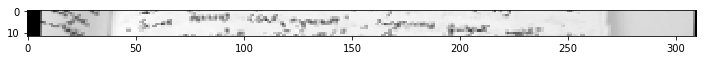

In [11]:
plt.figure(figsize=(12,2))
plt.imshow(src3[60:72,:], cmap='gray')

In [12]:
def calc_haar_feature_v(rows, filter_height=12, filter_width=4, h1=3, h2=8):
    tmpd = np.abs(rows[1:,:]-rows[:-1,:])
    tmp1 = np.mean(tmpd[:h1], axis=0)
    tmp2 = np.mean(tmpd[h1:h2], axis=0)
    tmp3 = np.mean(tmpd[h2:], axis=0)
    tmpr = np.array([(np.median(tmp1[i:(i+filter_width)]), np.median(tmp2[i:(i+filter_width)]), np.median(tmp3[i:(i+filter_width)])) for i in range(len(tmp1)-filter_width)])
    tmpf = (tmpr[:,1] / (np.maximum(tmpr[:,0], tmpr[:,2]) + 0.1))
    return tmpf

def calc_haar_feature_h(img, filter_height=4, filter_width=4):
    tmp = np.abs(img[:,1:]-img[:,:-1])
    tmpf = np.zeros_like(tmp[:,filter_width:])
    for i in range(filter_width):
        if i == filter_width - 1:
            tmpf = tmpf + tmp[:, (i+1):]
        else:
            tmpf = tmpf + tmp[:,(i+1):(-filter_width+i+1)]
    return np.array([np.median(tmpf[i:(i+filter_height), :], axis=0) for i in range(len(tmpf)-filter_height)])

def restore_img(flt, f_w, f_h):
    (sz_h, sz_w) = flt.shape
    res = np.zeros((sz_h+f_h, sz_w+f_w))
    for i in range(f_h):
        for j in range(f_w):
            res[i:(i+sz_h),j:(j+sz_w)] = res[i:(i+sz_h),j:(j+sz_w)] + flt
    return res/(f_w*f_h)

def calc_haar_feature(rows, filter_height=12, filter_width=4, h1=3, h2=8):
    tmpd = np.abs(rows[1:,:]-rows[:-1,:])
    tmpq = np.median(np.abs(rows[h1:h2,1:]-rows[h1:h2,:-1]), axis=0)
    tmpq2 = np.cumsum(tmpq)
    tmpq3 = tmpq2[(filter_width-1):]-tmpq2[:-(filter_width-1)]
    
    tmp1 = np.mean(tmpd[:h1], axis=0)
    tmp2 = np.mean(tmpd[h1:h2], axis=0)
    tmp3 = np.mean(tmpd[h2:], axis=0)
    tmpr = np.array([(np.median(tmp1[i:(i+filter_width)]),
                      np.median(tmp2[i:(i+filter_width)]),
                      np.median(tmp3[i:(i+filter_width)])) for i in range(len(tmp1)-filter_width)])
    tmpf = (tmpr[:,1]*tmpq3 / (np.maximum(tmpr[:,0], tmpr[:,2]) + 0.01))
    return tmpf


In [13]:
%%time
#res_v = [calc_haar_feature_v(src3[i:(i+12)]) for i in range(len(src3)-12)]
#res_h = calc_haar_feature_h(src3, 4, 4)
res = np.array([calc_haar_feature(src3[i:(i+12)]) for i in range(len(src3)-12)])

Wall time: 16.9 s


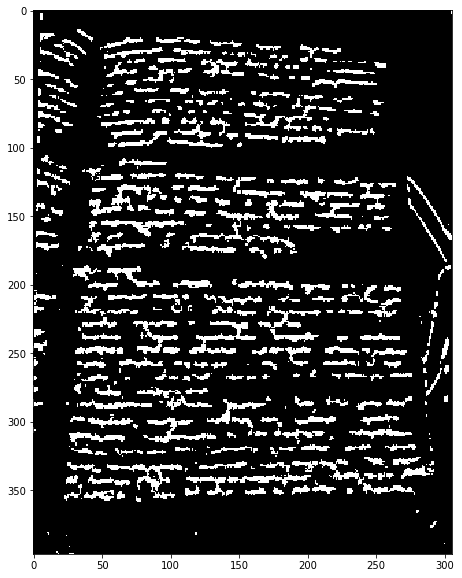

In [14]:
plt.figure(figsize=(14,10))
plt.imshow(res>0.3, cmap='gray')

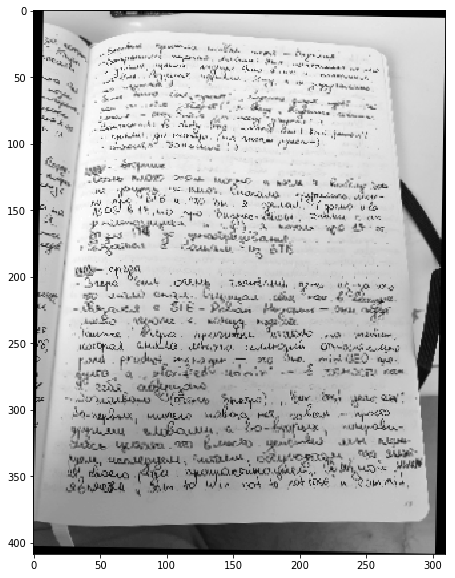

In [15]:
plt.figure(figsize=(14,10))
plt.imshow(src3, cmap='gray')

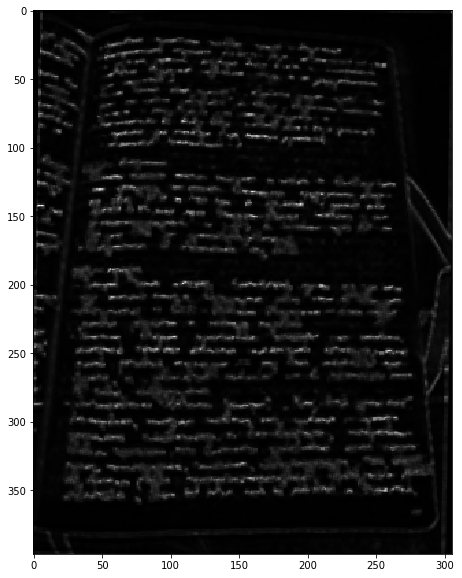

In [16]:
plt.figure(figsize=(14,10))
plt.imshow(res**0.5, cmap='gray')

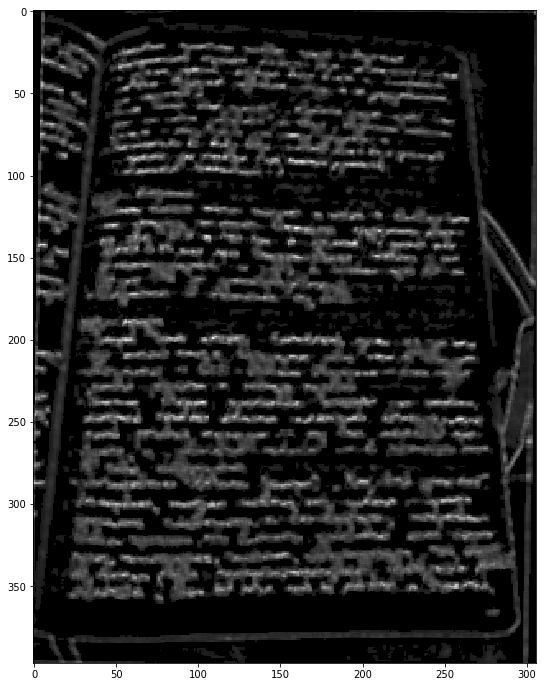

In [17]:
tmp0 = res**0.3
tmp1 = (tmp0 - np.min(tmp0))/(np.max(tmp0) - np.min(tmp0))
tmp1c = np.percentile(tmp0, 10)
tmp1[tmp1 < tmp1c] = 0
plt.figure(figsize=(14,12))
plt.imshow(tmp1, cmap='gray')

In [18]:
am1 = np.argmax(tmp1)
am1i = am1 // tmp1.shape[1]
am1j = am1 % tmp1.shape[1]

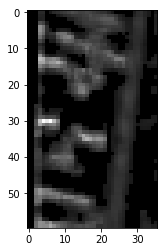

In [86]:
plt.imshow(tmp1[(am1i-30):(am1i+30), 0:(am1j+30)], cmap='gray')

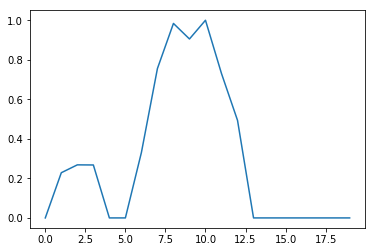

In [20]:
plt.plot(tmp1[am1i, np.array(range(-10,10))+am1j])

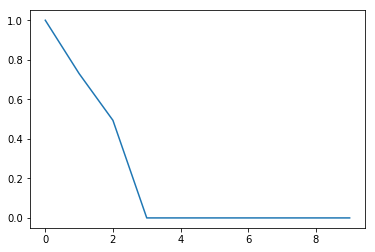

In [27]:
plt.plot(tmp1[am1i, np.array(range(10))+am1j])

In [213]:
def bbox_dx(src, rows, x, dxs, cutoff=0.3):
    xs = x + dxs
    xs = xs[(xs >= 0) & (xs < src.shape[1])]
    if len(xs) == 0:
        return 0
    if type(rows) in (list, np.array, np.ndarray, tuple) and np.max(rows)>np.min(rows):
        tmp = np.percentile(src[np.min(rows):np.max(rows), xs], q=60, axis=0)
    else:
        tmp = src[np.min(rows), xs]
    dd = 0
    while dd < len(xs):
        if tmp[dd] < cutoff:
            return max(0, dd - 1)
        dd += 1
    return dd-1

def bbox_dy(src, cols, y, dys, cutoff=0.3):
    ys = y + dys
    ys = ys[(ys >= 0) & (ys < src.shape[0])]
    if len(ys) == 0:
        return 0
    if type(cols) in (list, np.array, np.ndarray, tuple) and np.max(cols)>np.min(cols):
        tmp = np.percentile(src[ys, np.min(cols):np.max(cols)], q=10, axis=1)
    else:
        tmp = src[ys, np.min(cols)]
    dd = 0
    while dd < len(ys):
        if tmp[dd] < cutoff:
            return max(0, dd - 1)
        dd += 1
    return dd-1

def bbox_dd(src, bbox, d, vcutoff=0.3, hcutoff=0.3):
    rng = np.array(range(d+1))
    dyp = bbox_dy(src, (bbox[1], bbox[3]), np.max((bbox[0], bbox[2])), rng, vcutoff)
    dyn = bbox_dy(src, (bbox[1], bbox[3]), np.min((bbox[0], bbox[2])), -rng, vcutoff)
    dxp = bbox_dx(src, (bbox[0], bbox[2]), np.max((bbox[1], bbox[3])), rng, hcutoff)
    dxn = bbox_dx(src, (bbox[0], bbox[2]), np.min((bbox[1], bbox[3])), -rng, hcutoff)
    return (bbox[0]-dyn, bbox[1]-dxn, bbox[2]+dyp, bbox[3]+dxp)

def bbox_percentile(src, bbox, q=0.5):
    return np.percentile(src[bbox[0]:bbox[2], bbox[1]:bbox[3]], q)

def find_bbox(src, i0, j0, d=10, vcutoff=0.3, hcutoff=0.3):
    bb0 = (i0, j0, i0, j0)
    bb1 = bbox_dd(src, bb0, d, vcutoff, hcutoff)
    while bb0 != bb1:
        bb0 = bb1
        bb1 = bbox_dd(src, bb0, d, vcutoff, hcutoff)
    return bb1

def find_all_bbox(src, d=10, vcutoff=0.3, hcutoff=0.3):
    res = []
    tmp = np.copy(src)
    while True:
        ind = np.argmax(tmp)
        i0 = ind // src.shape[1]
        j0 = ind % src.shape[1]
        if tmp[i0, j0] < np.max([vcutoff, hcutoff]):
            return res
        bb = find_bbox(tmp, i0, j0, d, vcutoff, hcutoff)
        if np.min([abs(bb[2]-bb[0]), abs(bb[3]-bb[1])]) == 0:
            tmp[i0, j0] = 0
        else:
            tmp[bb[0]:(bb[2]+1),bb[1]:(bb[3]+1)] = 0
            res.append(bb)
            
def plot_box(bbox, col='b'):
    x = [bbox[1], bbox[3], bbox[3], bbox[1], bbox[1]]
    y = [bbox[0], bbox[0], bbox[2], bbox[2], bbox[0]]
    plt.plot(x, y, c=col)

In [122]:
bb1 = bbox_dd(tmp1, (am1i, am1j, am1i, am1j), 10, cutoff=0.3)
print(bb1)
bb2 = bbox_dd(tmp1, bb1, 10)
print(bb2)
bb1==bb2

(142, 2, 144, 8)
(142, 2, 144, 8)


True

In [94]:
bbox_dy(tmp1, (am1j, am1j), am1i, np.array(range(10)))

(6, 6) 142 [0 1 2 3 4 5 6 7 8 9] 0.3


2

In [125]:
tmp1[bb2[0]:bb2[2],bb2[1]:bb2[3]]

array([[0.33099839, 0.75565607, 0.98385507, 0.9052572 , 1.        ,
        0.73020167],
       [0.33698858, 0.6543182 , 0.50894855, 0.43832026, 0.49227777,
        0.5063976 ]])

In [133]:
bbox_percentile(tmp1, bb2)

0.33132785279727783

In [136]:
find_bbox(tmp1, am1i, am1j)

(142, 2, 144, 8)

In [235]:
%%time
bbs = find_all_bbox(tmp1, vcutoff=0.3, hcutoff=0.05)

Wall time: 1.92 s


In [236]:
len(bbs)

525

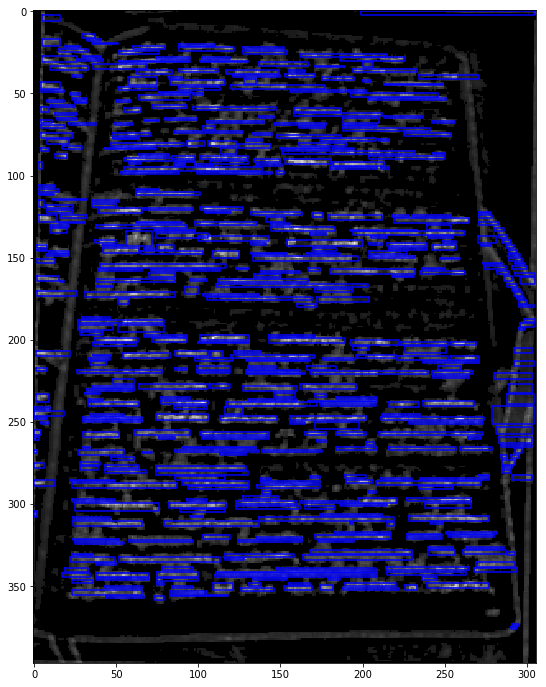

In [237]:
plt.figure(figsize=(14,12))
plt.imshow(tmp1, cmap='gray')
for bbox in bbs[:500]:
    plot_box(bbox)

In [243]:
plt.figure(figsize=(14,12))
#plt.imshow(srcr, cmap='gray')
for bbox in bbs[:300]:
    bbox_t = (bbox[0]+2, bbox[1], bbox[2]+10, bbox[3]+4)
    bbox_t2 = tuple(x*10 for x in bbox_t)
    #plot_box(bbox_t2)

<Figure size 1008x864 with 0 Axes>

In [242]:
for bbox in bbs[:50]:
    bbox_t = (bbox[0]+2, bbox[1], bbox[2]+10, bbox[3]+4)
    bbox_t2 = tuple(x*10 for x in bbox_t)
    #plt.figure(figsize=(14,12))
    #plt.imshow(srcr[bbox_t2[0]:bbox_t2[2], bbox_t2[1]:bbox_t2[3]], cmap='gray')